# Reading and extracting data from calcium imaging videos (.tif) 
(originally written by Abel Corver for the publication "Nonlinear integration of sensory inputs and behavioral state by a single neuron in C. elegans" doi: https://doi.org/10.1101/2025.04.05.647390) 

Last updated: 10.16.25 (Amanda Ray, annotations for publication)

This code will walk through how our calcium imaging videos (originally saved on Nikon Elements software as .nd2 files, and then exported as .tif files), are processed using FLIKA to extract fluorescence data. We convert the data into numpy files, which are then processed in the provided 'Processing Neuron Data (Smoothing and Normalization).ipynb' notebook.

Note that videos are not provided and the numpy files are provided for the sake of size. This is just explaining how our videos are processed if you are curious, or if you want to use with your data. 


In [1]:
# Mac path format: /Users/username/folder/file.tif
# Windows path format: C:\\folder\\file.tif

pathname = 'C:\\Users\\Gordus Lab\\Amanda\\Python Processing\\'
filename = 'aligned-Crop_Export_041222_CX17432-elt-2_inx-1_rig-3NLS_gcy-28d_GC7s_2B-P3_T0001.tif'

fname  = pathname+filename

In [11]:
## Imports ##

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from tqdm import tqdm_notebook as tqdm
import flika as flk
from flika.window import Window as flw
from shapely.geometry.polygon import Polygon
from shapely.geometry.point import Point
import glob

### Annotate ROIs

In [5]:
# Open Flika
flkApp = flk.start_flika()

Starting flika
Starting flika inside IPython


In [6]:
# Determine text file to save/load from
fnameFlika = fname.replace('.tif','') + '.txt'
fnameFlika

'C:\\Users\\Gordus Lab\\Amanda\\Python Processing\\aligned-Crop_Export_041222_CX17432-elt-2_inx-1_rig-3NLS_gcy-28d_GC7s_2B-P3_T0001.txt'

In [7]:
np.save(fname + '_test.npy', fnameFlika)

In [8]:
# Create reference for ROI annotation

img = tifffile.imread(fname)
refImg = np.mean(img, axis=0)

In [9]:
# Read and display reference image
# For consistency, I always select the first ROI as AVA, the second as AIB, third as AIA, 
# and BG is always last.

flwROIs = flw(refImg)

In [12]:
# Did we already start an annotation?
if os.path.exists(fnameFlika):
    flk.roi.open_rois(fnameFlika)

In [13]:
# When we're done manually annotating, run this to save ROIs
flwROIs.save_rois(fnameFlika)

In [14]:
# Load ROIs
roi = flk.roi.open_rois(fnameFlika)
ROIs = [x.getPoints() for x in roi]

In [15]:
# Convert to polygons
ROIs = [Polygon(x) for x in ROIs]

In [16]:
# Create a mask for every ROI
masks = []
for roi in tqdm(ROIs, desc='Compute masks', leave=False):
    mask = np.zeros(img.shape[1:], dtype=np.bool)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if roi.contains(Point(x, y)):
                mask[x, y] = True
    masks.append(mask)

C:\Users\Gordus Lab\Anaconda3\envs\redux\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Compute masks:   0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
F = []
for mask in masks:
    F.append( np.mean(img[:,mask], axis=1) )
F = np.array(F).T
F.shape

(2300, 4)

In [18]:
# Save data
fnameF = fname.replace('.tif','') + '.F.npy'
np.save(fnameF, F)

#np.load(fnameF)

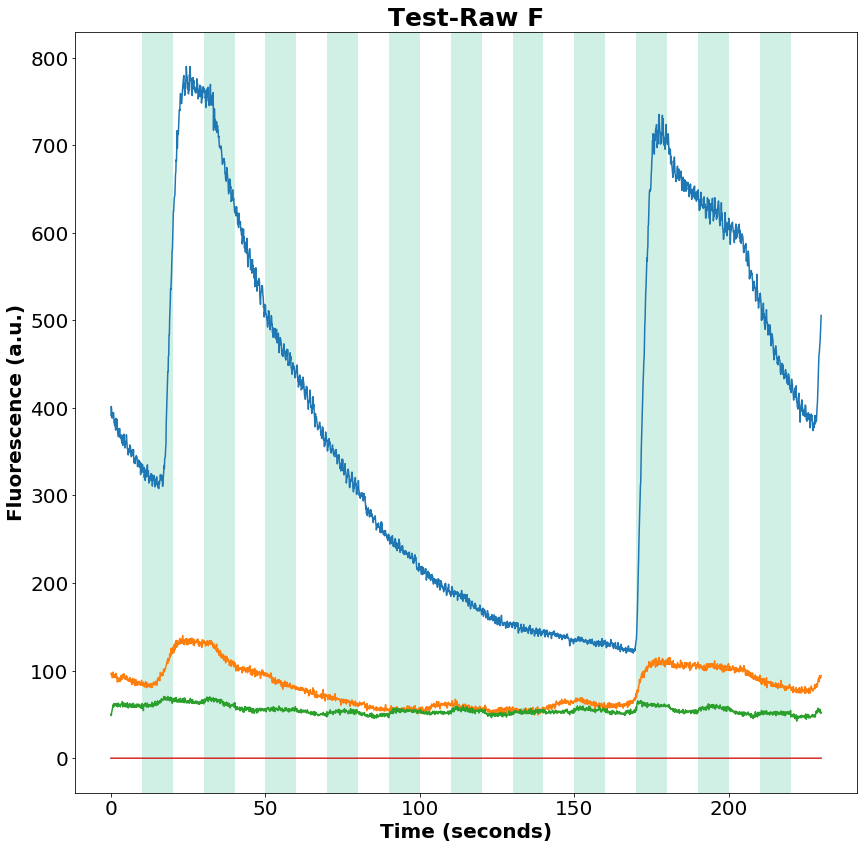

In [29]:
## Generate graph of fluorescence data from selected ROIs ##
# Will highlight 10 second pulses, representative of stimulus 

frames = range(len(F))
time = []

for n in frames:
    time_frame = n/10 
    time.append(time_frame)

shp = int(len(F)/10)
pulse = np.ones(10) # pulse length
pulse_start = np.arange(0,shp,20) # pulse initiation frames
pulse_seq = np.zeros(shp)  # initial pulse sequence is zeros for every frame
for i in pulse_start:
    pulse_seq[i:i+10] = pulse #pulse seq starts out 1 then 0

fig, ax = plt.subplots(1,1, figsize=(14,14), facecolor='w')
ax.plot(time,F)
ax.set_title('Test-Raw F', fontsize = 25, fontweight = 'bold') 
ax.set_xlabel('Time (seconds)', fontsize=20, fontweight = 'bold')
ax.set_ylabel('Fluorescence (a.u.)', fontsize=20, fontweight = 'bold')
ax.tick_params(axis= 'both', labelsize=20)
for i in range(shp): 
    if pulse_seq[i] == 0:
        ax.axvspan(i,i+1, facecolor='mediumaquamarine', alpha = 0.3) #Can change the color to whatever you want
#fig.savefig(fnameF + '-raw.png', dpi = 300)

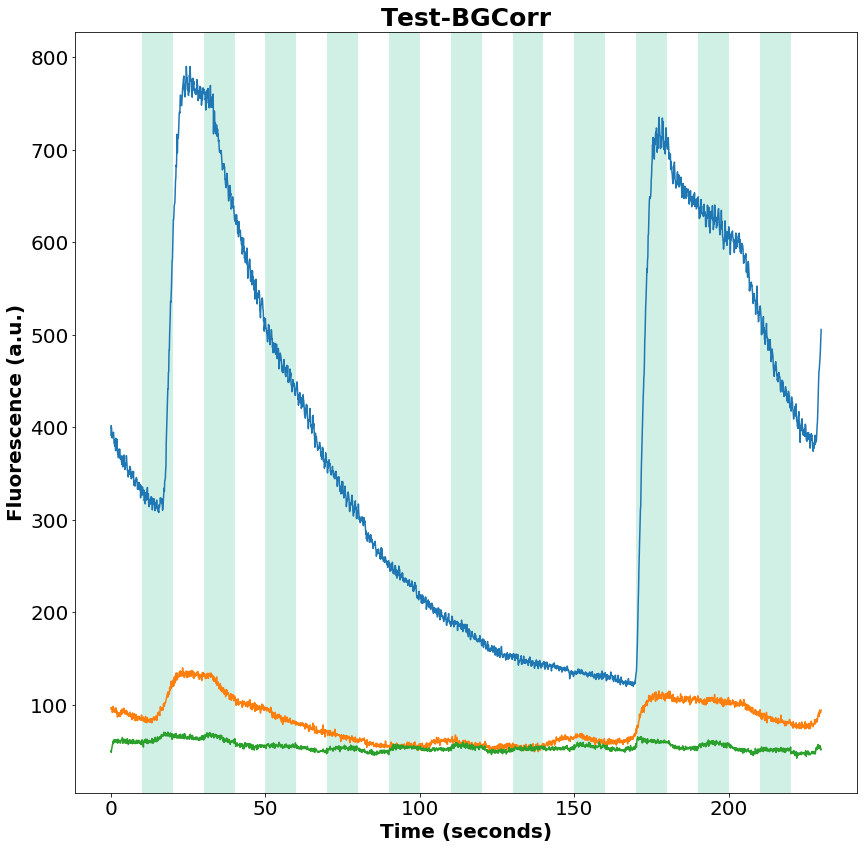

In [28]:
## Background subtracted graph of fluorescence data ##
# Will highlight 10 second pulses, representative of stimulus

F_corr = F

data = range(0, len(F_corr[-1,:]))

# Like I mentioned above, background is always last to make processing easier and consistent
for i in data:
    F_corr[:,i] = F_corr[:,i] - F_corr[:,-1]
    
F_corr = F_corr[:,:-1]
    
fig, ax = plt.subplots(1,1, figsize=(14,14), facecolor='w')
ax.plot(time, F_corr)
ax.set_title('Test-BGCorr', fontsize = 25, fontweight = 'bold')
ax.set_xlabel('Time (seconds)', fontsize=20, fontweight = 'bold')
ax.set_ylabel('Fluorescence (a.u.)', fontsize=20, fontweight = 'bold')
ax.tick_params(axis= 'both', labelsize=20)
for i in range(shp): 
    if pulse_seq[i] == 0:
        ax.axvspan(i,i+1, facecolor='mediumaquamarine', alpha = 0.3)
#fig.savefig(fnameF + '-bgcorr.png', dpi = 300)